In [32]:
#import export_network
#import cartopy
import pypsa
import plotly.offline as pltly
import matplotlib.pyplot as plt, mpld3
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import logging
import warnings
logging.basicConfig(level=logging.ERROR)

In [33]:
network = pypsa.Network(name='Texas')
network.import_from_netcdf('texas_grid.netcdf')
removed_lines = pd.DataFrame()
reduced_generators = pd.DataFrame()
buses_disconnected = pd.DataFrame()

In [34]:
def remove_lines_random(network,n=1):
    global removed_lines
    lines_to_remove = network.lines.sample(n)
    removed_lines = removed_lines.append(lines_to_remove)
    network.mremove("Line",lines_to_remove.index.to_series())
    return network

def reduce_generators_random(network,n=1,reduction_factor=0):
    global reduced_generators
    generators_to_shutdown = network.generators.sample(n)
    network.mremove("Generator",generators_to_shutdown.index.to_series())
    generators_to_shutdown['p_nom'] = generators_to_shutdown['p_nom']*reduction_factor
    network.import_components_from_dataframe(generators_to_shutdown,"Generator")
    generators_to_shutdown['reduction_factor'] = reduction_factor
    reduced_generators = reduced_generators.append(generators_to_shutdown)
    return network

def disconnect_buses_random(network,n=1):
    global removed_lines
    global buses_disconnected
    buses_to_disconnect = network.buses.sample(n)
    buses_disconnected = buses_disconnected.append(buses_to_disconnect)
    buses_to_disconnect = buses_to_disconnect.index.to_series()
    lines = network.lines.copy()
    lines_to_remove = lines[(lines['bus0'].isin(buses_to_disconnect)) | (lines['bus1'].isin(buses_to_disconnect))]
    removed_lines = removed_lines.append(lines_to_remove)
    network.mremove("Line",lines_to_remove.index.to_series())
    return network
    

In [35]:
print(f"The network has {network.lines.shape[0]} lines.")
print(f"The network has {network.buses.shape[0]} buses.")
print(f"The network has {network.generators.shape[0]} generators.")
disconnect_buses_random(network, 10)
print(f"The network has {network.buses.shape[0]} buses.")



The network has 3205 lines.
The network has 1999 buses.
The network has 597 generators.
The network has 1999 buses.


In [47]:
venom = network.buses.v_nom/500
venom.describe()


#p_out = network.generators.p_nom
#p_out.describe()
#bus_colors = pd.Series("r", network.buses.index)

#network.plot(bus_colors= venom)
#bus_colors[p_out<0] = "b"
#test = network.plot(bus_colors=venom, bus_cmap=plt.cm.jet)
#network.plot(bus_colors=venom, bus_cmap=plt.cm.jet)
jet = cm = plt.get_cmap('jet') 
#network.iplot(bus_colors=venom, bus_cmap= jet)
#mpld3.fig_to_html(network)
fig = plt.figure()
#mpld3.plugins.PointHTMLTooltip(network)
#mpld3.plugins.connect(network, PointHTMLTooltip)
#mpld3.display()


<Figure size 432x288 with 0 Axes>

In [21]:

#print(network.buses_t.q)
#network.buses_t.q
bus_colors = pd.Series("r",network.buses.index)
bus_colors[p_out == "False"] = "b"

#network.plot(bus_colors=bus_colors,
             title="Reactive power feed-in (red=+ve, blue=-ve)");

IndentationError: unexpected indent (3581880734.py, line 7)

In [28]:
# Color Scale code plt -> plotly 
magma_cmap = plt.cm.get_cmap('magma')
viridis_cmap = plt.cm.get_cmap('viridis')

viridis_rgb = []
magma_rgb = []
norm = plt.colors.Normalize(vmin=0, vmax=255)

for i in range(0, 255):
       k = plt.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
       magma_rgb.append(k)

for i in range(0, 255):
       k = plt.colors.colorConverter.to_rgb(viridis_cmap(norm(i)))
       viridis_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = list(matplotlib_to_plotly(magma_cmap, 255))
viridis = list(matplotlib_to_plotly(viridis_cmap, 255))


AttributeError: module 'matplotlib.pyplot' has no attribute 'colors'

In [9]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=900)
    plt.show()

/Users/chriscallahan/opt/anaconda3/lib/python3.9/site-packages/pypsa/plot.py:149: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



OrderedGraph with 1999 nodes and 3205 edges
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 2. 0.]]


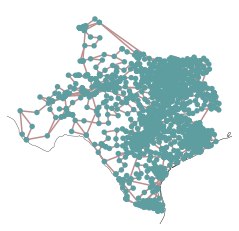

In [22]:
#pd.set_option("display.max_rows", 2000)
#pd.options.display.max_rows = 999
#print(network.adjacency_matrix())

network.plot()

print(network.graph())

#plt.pyplab.spy(network)
net_adj_mat = network.adjacency_matrix()
net_arr = net_adj_mat.toarray()
print(net_arr)


#show_graph_with_labels(net_adj_mat)


#G = network.DiGraph(input_data.values)
#network.bus[3001006]


In [6]:
print("Removing lines")
print(f"Initial number of lines: {network.lines.shape[0]}")
remove_lines_random(network)
print(f"Resulting number of lines: {network.lines.shape[0]}")
print("Removed Lines:")
display(removed_lines)

Removing lines
Initial number of lines: 3205
Resulting number of lines: 3204
Removed Lines:


,name,bus0,bus1,r,x,b,rateA,rateB,rateC,ratio,...,terrain_factor,num_parallel,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
102050,102050,3008157,3005124,0.01256,0.05593,0.0082,149.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print("Disconnecting buses")
print(f"Initial number of lines: {network.lines.shape[0]}")
disconnect_buses_random(network)
print(f"Resulting number of lines: {network.lines.shape[0]}")
print("Removed Lines:")
display(removed_lines)
print("Buses Disconnected:")
display(buses_disconnected)

Disconnecting buses
Initial number of lines: 3204
Resulting number of lines: 3199
Removed Lines:


,name,bus0,bus1,r,x,b,rateA,rateB,rateC,ratio,...,terrain_factor,num_parallel,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
102050,102050,3008157,3005124,0.01256,0.05593,0.00820,149.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102579,102579,3006025,3006060,0.00724,0.04134,0.00621,250.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102580,102580,3006121,3006025,0.00399,0.02277,0.00342,221.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102581,102581,3006025,3006337,0.00373,0.02598,0.00425,221.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102582,102582,3006025,3006337,0.00373,0.02598,0.00425,221.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102583,102583,3006352,3006025,0.00808,0.01942,0.00264,221.0,0.0,0.0,0.0,...,1.0,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Buses Disconnected:


,y,x,v_nom,v_mag_pu_max,v_mag_pu_min,type,carrier,unit,v_mag_pu_set,control,sub_network
name,,,,,,,,,,,
3006025,29.59,-98.5253,115.0,1.1,0.9,,AC,None,1.0,PQ,


In [8]:
print('Reducing Generators Capacity:')
reduce_generators_random(network)
print("Generators Reduced:")
display(reduced_generators)

Reducing Generators Capacity:
Generators Reduced:


,bus,p_nom,Qmax,Qmin,Vg,mBase,p_nom_max,p_nom_min,Pc1,Pc2,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,reduction_factor
name,,,,,,,,,,,,,,,,,,,,,
13167,3006104,0.0,30.79,-6.72,1.04,72.6,60.5,18.15,0,0,...,0,0,1,0,NaN,NaN,1.0,1.0,0.0,0
